C:\Users\Jothimani\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


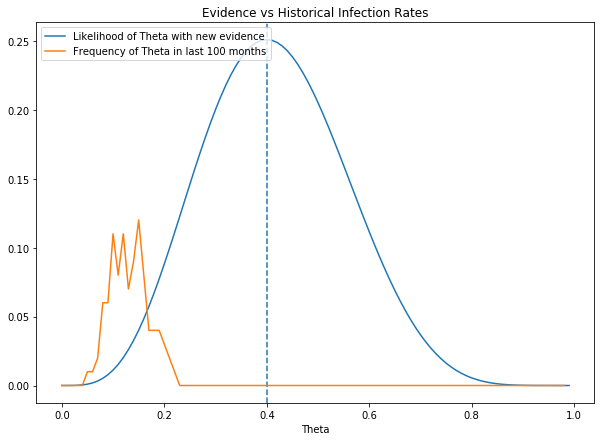

In [2]:
import numpy as np
from scipy.misc import factorial
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.stats import beta

def likelihood(theta, n, x):
    """
    :param theta: probability of infection
    :param n: n testing
    :param x: x positive
    :return likelihood probability
    """
    return (factorial(n) / (factorial(n-x) * factorial(x))) * (1 - theta) ** (n - x) * (theta ** x)

chance_of_infection = 0.4

n_people = 10                                      # Number of people
n_infections = int(n_people * chance_of_infection) # Number of infections
infection_rate = n_infections / n_people           # infection rate

# likelihoods for different theta
possible_thetas = [i / 100 for i in range(100)] # theta values
likelihoods = [likelihood(theta, n_people, n_infections) for theta in possible_thetas]

# Maximum likeliness estimation
mle = possible_thetas[np.argmax(likelihoods)]

N = 100                                     # 100 prior months
true_a, true_b = 10, 60                     # a, b for the beta distribution
p = np.random.beta(true_a, true_b, size=N)  # Sample from a Beta distribution (100,)

people_per_month = np.random.randint(2000, 10000, size=N)  
# We test about 2000-10000 per month. People tested in each 100 months (100,)
infection_per_month = np.random.binomial(people_per_month, p).astype(float) 
# Use binomial dist., Infection in each 100 months (100,)
infections_rates = infection_per_month / people_per_month

plt.figure(figsize=(10, 7))
plt.axvline(mle, linestyle ="--")
line1, = plt.plot(possible_thetas, likelihoods)

bins = [x/100 for x in range(100)]
counts, bins = np.histogram(infections_rates, bins=bins)
counts = counts / counts.sum()
line2, = plt.plot(bins[:-1], counts)
plt.xlabel("Theta")
plt.title("Evidence vs Historical Infection Rates")
plt.legend((line1, line2), ('Likelihood of Theta with new evidence', 'Frequency of Theta in last 100 months')
           , loc = 'upper left')
plt.show()



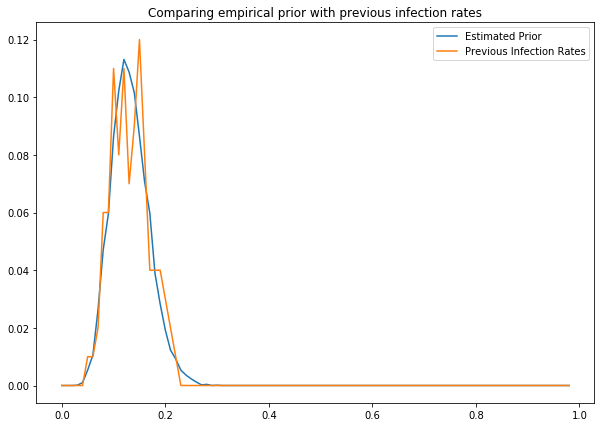

logp = -1.1146, ||grad|| = 1.8571: 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00, 1001.23it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 11000/11000 [00:11<00:00, 994.23draws/s]
The acceptance probability does not match the target. It is 0.8792315888911721, but should be close to 0.8. Try to increase the number of tuning steps.
logp = -20.048, ||grad|| = 25: 100%|███████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.49it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains: 100%|████████████████████████████████████████████████████| 11000/11000 [00:09<00:00, 1104.54draws/s]
logp = -199.26, ||grad|| = 256.43: 100%|███████████████████████████████████████████████| 7/7 [00:00<00

In [3]:
# Model the data with a beta function
prior_a, prior_b = beta.fit(infections_rates, floc = 0, fscale = 1)[0:2] # Fit data to find a & b for the beta dist.
prior = beta(prior_a, prior_b)

prior_samples = prior.rvs(10000)  # Sample from the prior
beta_sample_counts, bins = np.histogram(prior_samples, bins)
total = beta_sample_counts.sum()
beta_sample_counts = [x / total for x in beta_sample_counts]

plt.figure(figsize=(10, 7))

line1, = plt.plot(bins[:-1], beta_sample_counts)

hist_rates, bins = np.histogram(infections_rates, bins)
total = hist_rates.sum()
hist_rates = [x/total for x in hist_rates]
line2, = plt.plot(bins[:-1], hist_rates)

plt.legend((line1, line2), ('Estimated Prior' , 'Previous Infection Rates'))
plt.title("Comparing empirical prior with previous infection rates")
plt.show()

# Markov chain Monte Carlo model
sample_sizes = [10, 100, 1000, 10000]
#sample_sizes = [10]
count_cases = len(sample_sizes)
traces = [None] * count_cases
for i, people_count in enumerate(sample_sizes):
    infection_count = int(people_count * chance_of_infection)  # Number of infections

    with pm.Model() as model:
        people_count = np.array([people_count])
        infections = np.array([infection_count])

        theta_prior = pm.Beta('prior', 10, 60)
        observations = pm.Binomial('obs', n = people_count
                                   , p = theta_prior
                                   , observed = infections)

        start = pm.find_MAP()

        trace = pm.sample(5000, start=start)
        traces[i] = trace

prior_counts, slots = np.histogram(prior_samples, bins)
prior_counts = prior_counts / prior_counts.sum()



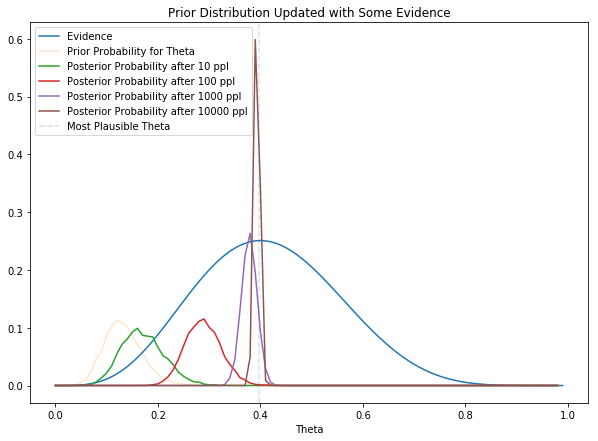

In [4]:
posterior_counts = [None] * count_cases
for i in range(count_cases):
    posterior_counts[i], posterior_bins = np.histogram(traces[i]['prior'] , bins=bins)
    posterior_counts[i] = posterior_counts[i] / posterior_counts[i].sum()
most_plausible_theta = np.mean(trace[i]['prior'])

plt.figure(figsize=(10, 7))
line1, = plt.plot(possible_thetas, likelihoods)
line2, = plt.plot(slots[:-1], prior_counts, alpha = .2)

line = [None] * count_cases
for i in range(count_cases):
    line[i], = plt.plot(slots[:-1], posterior_counts[i])

line3 = plt.axvline(most_plausible_theta, linestyle ="--", alpha = .2)

if count_cases > 1:
    plt.legend((line1, line2, line[0], line[1], line[2], line[3], line3), ('Evidence'
                                             , 'Prior Probability for Theta'
                                             , 'Posterior Probability after 10 ppl'
                                             , 'Posterior Probability after 100 ppl'
                                             , 'Posterior Probability after 1000 ppl'
                                             , 'Posterior Probability after 10000 ppl'
                                             , 'Most Plausible Theta'
                                              ), loc = 'upper left')
else:
    plt.legend((line1, line2, line[0], line3), ('Evidence'
                                             , 'Prior Probability for Theta'
                                             , 'Posterior Probability after 10 ppl'
                                             , 'Most Plausible Theta'
                                              ), loc = 'upper left')
plt.xlabel("Theta")
plt.title("Prior Distribution Updated with Some Evidence")
plt.show()